In [165]:
#IMPORT LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [166]:
#IMPORT DATA
#DATA UNDERSTANDING

In [167]:
#READ THE DATASET
dataTrain=pd.read_csv('water_usage_train.csv')

dataTrain.head()

,User ID,ID national,full name,family member,seasons,weekly,monthly,by cycle
0,11666,9873698843,منير مد مد حميد,8,Spring,7.11,33.14,83.61
1,75296,9456605169,هبةة عبد الساتر مجدلاوية علان,2,Summer,2.07,8.05,25.89
2,20350,9451799815,سامر عبدالغني مرزوق بداير,4,Summer,4.70,15.89,55.92
3,94396,9582029028,حنبن عبد الحميد مجدي البسطامي,8,Winter,4.13,14.74,44.70
4,19178,9507702961,ايه محمد. مرجان عقيل,9,Spring,8.63,30.77,102.08


In [168]:
# --- Tariff Constants (as per image_1e811f.png for Residential Citizen) ---
# Water Tariff Rates per Cubic Meter (OMR/m³)
TIER_1_RATE = 0.200  # For 0 - 5 m³
TIER_2_RATE = 0.300  # For 6 - 10 m³
TIER_3_RATE = 0.400  # For 11 - 20 m³
TIER_4_RATE = 0.660  # For > 20 m³

# Sewage Tariff (if applicable, based on image)
SEWAGE_FIXED_MONTHLY_CHARGE = 2.100 # OMR
SEWAGE_RATE_PER_M3 = 0.154 # OMR/m³ based on water consumption

def calculate_actual_omr_bill(monthly_consumption_m3, include_sewage=False):
    """
    Calculates the actual OMR water bill based on monthly consumption and tiered tariff rates
    for Residential Citizen accounts, including an option for sewage charges.

    Args:
        monthly_consumption_m3 (float): Monthly water consumption in cubic meters (m³).
        include_sewage (bool): If True, includes sewage charges in the total bill.

    Returns:
        float: The calculated actual bill in Omani Rial (OMR).
    """
    water_bill = 0.0

    if monthly_consumption_m3 <= 5:
        water_bill = monthly_consumption_m3 * TIER_1_RATE
    elif monthly_consumption_m3 <= 10:
        water_bill = (5 * TIER_1_RATE) + \
                     ((monthly_consumption_m3 - 5) * TIER_2_RATE)
    elif monthly_consumption_m3 <= 20:
        water_bill = (5 * TIER_1_RATE) + \
                     (5 * TIER_2_RATE) + \
                     ((monthly_consumption_m3 - 10) * TIER_3_RATE)
    else: # monthly_consumption_m3 > 20
        water_bill = (5 * TIER_1_RATE) + \
                     (5 * TIER_2_RATE) + \
                     (10 * TIER_3_RATE) + \
                     ((monthly_consumption_m3 - 20) * TIER_4_RATE)
    
    total_bill = water_bill

    if include_sewage:
        total_bill += SEWAGE_FIXED_MONTHLY_CHARGE
        total_bill += (monthly_consumption_m3 * SEWAGE_RATE_PER_M3) # Sewage per m³ based on water consumption

    return round(total_bill, 3) # Round to 3 decimal places for currency precision

In [169]:
# Apply the function to calculate the actual OMR bill.
# Set include_sewage=True if you want to include sewage charges in the target bill.
print("\n--- Calculating Actual OMR bill based on tariff ---")
dataTrain['Actual OMR bill'] = dataTrain['monthly'].apply(lambda x: calculate_actual_omr_bill(x, include_sewage=False))
print("'Actual OMR bill' column created based on tariff details (excluding sewage for now).")

# Display a sample of calculated bills (optional, for review)
print("\nSample of monthly usage vs. calculated actual bill:")
print(dataTrain[['monthly', 'Actual OMR bill']].head(10))


--- Calculating Actual OMR bill based on tariff ---
'Actual OMR bill' column created based on tariff details (excluding sewage for now).

Sample of monthly usage vs. calculated actual bill:
   monthly  Actual OMR bill
0    33.14           15.172
1     8.05            1.915
2    15.89            4.856
3    14.74            4.396
4    30.77           13.608
5    22.91            8.421
6    11.23            2.992
7    16.25            5.000
8    25.85           10.361
9    16.76            5.204


In [170]:
#DISPLAY THE NUMBER OF ROWS AND COLUMNS
dataTrain.shape

(99999, 9)

In [171]:
dataTrain.columns #to know the column names

Index(['User ID', 'ID national', 'full name', 'family member', 'seasons',
       'weekly', 'monthly', 'by cycle', 'Actual OMR bill'],
      dtype='object')

In [172]:
dataTrain['seasons'].unique() ##to know the unique models names

array(['Spring', 'Summer', 'Winter', 'Autumn'], dtype=object)

In [173]:
dataTrain['seasons'].value_counts() #to know the count of each models names

Autumn    25232
Spring    25052
Winter    24946
Summer    24769
Name: seasons, dtype: int64

In [174]:
#CHECKING AND DISPLAYING THE NULL VALUES IN EACH COLUMN
dataTrain.isnull().sum()

User ID            0
ID national        0
full name          0
family member      0
seasons            0
weekly             0
monthly            0
by cycle           0
Actual OMR bill    0
dtype: int64

In [175]:
dataTrain.shape

(99999, 9)

In [176]:
dataTrain.dtypes

User ID              int64
ID national          int64
full name           object
family member        int64
seasons             object
weekly             float64
monthly            float64
by cycle           float64
Actual OMR bill    float64
dtype: object

In [177]:
# List of columns to convert to float
columns_to_convert = [
    'full name',
    'seasons'
]

# Convert the specified columns to float
for column in columns_to_convert:
    dataTrain[column] = pd.to_numeric(dataTrain[column], errors='coerce')

# Verify the conversion
print(dataTrain.dtypes)

# Optional: Handle missing values
dataTrain.fillna(0, inplace=True)  # Replace NaN with 0 if necessary

User ID              int64
ID national          int64
full name          float64
family member        int64
seasons            float64
weekly             float64
monthly            float64
by cycle           float64
Actual OMR bill    float64
dtype: object


In [178]:
# Rename columns for clarity and consistency
dataTrain.rename(columns={
    'seasons': 'Season',
    'monthly': 'Monthly Consumption',
    'Actual OMR bill': 'Actual Bill OMR' # Renaming the newly created column for consistency
}, inplace=True)

print("Columns renamed to: 'Season', 'Monthly Consumption', 'Actual Bill OMR'.")
print("\nUpdated DataFrame columns:")
print(dataTrain.columns)

Columns renamed to: 'Season', 'Monthly Consumption', 'Actual Bill OMR'.

Updated DataFrame columns:
Index(['User ID', 'ID national', 'full name', 'family member', 'Season',
       'weekly', 'Monthly Consumption', 'by cycle', 'Actual Bill OMR'],
      dtype='object')


In [179]:
#EXPLORATORY DATA ANALYSIS (EDA)
#CHECKING THE CORRELATION BETWEEN THE NUMERICAL FEATURES

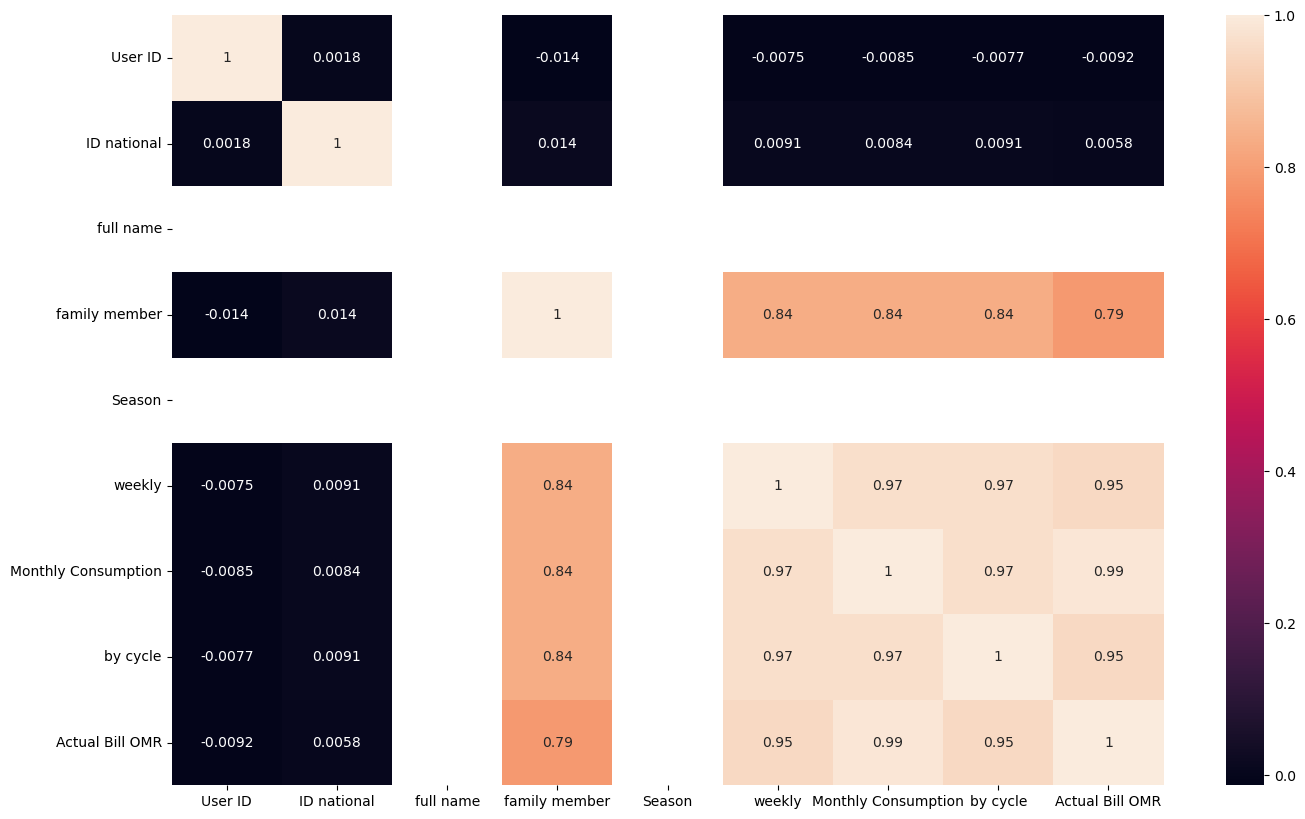

In [180]:
#HEAT MAP
plt.figure(figsize=(16,10))
numerical_features = dataTrain.select_dtypes(include=['number']).columns
corr = dataTrain[numerical_features].corr()
sns.heatmap(corr,annot=True)
plt.show()

In [181]:
#REGRESSION PLOT TO CHECK THE CORRELATION BETWEEN THE NUMERICAL FEATURES
#AND THE TARGET

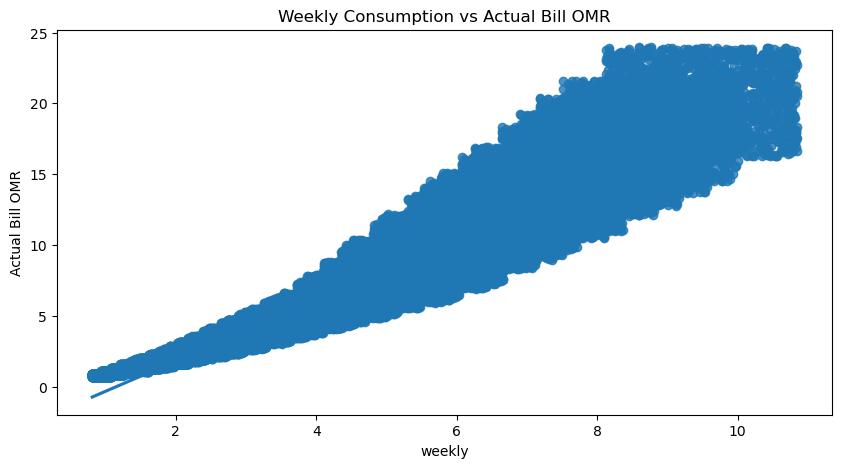

In [182]:
plt.figure(figsize=(10, 5))
sns.regplot(x='weekly', y='Actual Bill OMR', data=dataTrain) # <-- Changed 'monthly' to 'Monthly Consumption'
plt.title("Weekly Consumption vs Actual Bill OMR")
plt.show()

In [183]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(dataTrain['weekly'], dataTrain['Actual Bill OMR'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.9498392763457764  with a P-value of P = 0.0


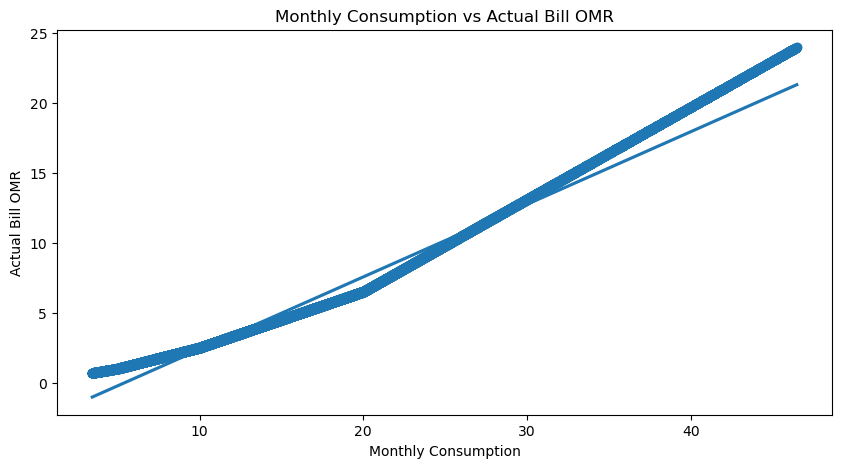

In [184]:
plt.figure(figsize=(10, 5))
sns.regplot(x='Monthly Consumption', y='Actual Bill OMR', data=dataTrain) # <-- Changed 'monthly' to 'Monthly Consumption'
plt.title("Monthly Consumption vs Actual Bill OMR")
plt.show()

In [185]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(dataTrain['Monthly Consumption'], dataTrain['Actual Bill OMR'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.9878747666530843  with a P-value of P = 0.0


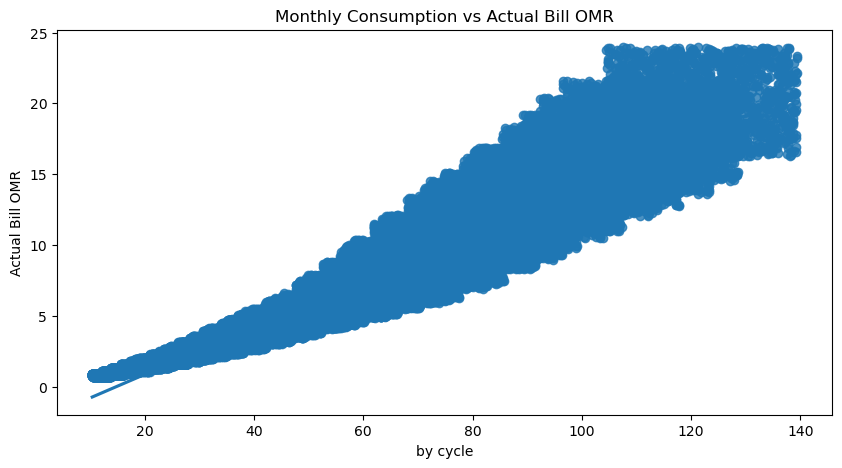

In [186]:
plt.figure(figsize=(10, 5))
sns.regplot(x='by cycle', y='Actual Bill OMR', data=dataTrain) # <-- Changed 'monthly' to 'Monthly Consumption'
plt.title("Monthly Consumption vs Actual Bill OMR")
plt.show()

In [187]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(dataTrain['by cycle'], dataTrain['Actual Bill OMR'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.9502671625069469  with a P-value of P = 0.0


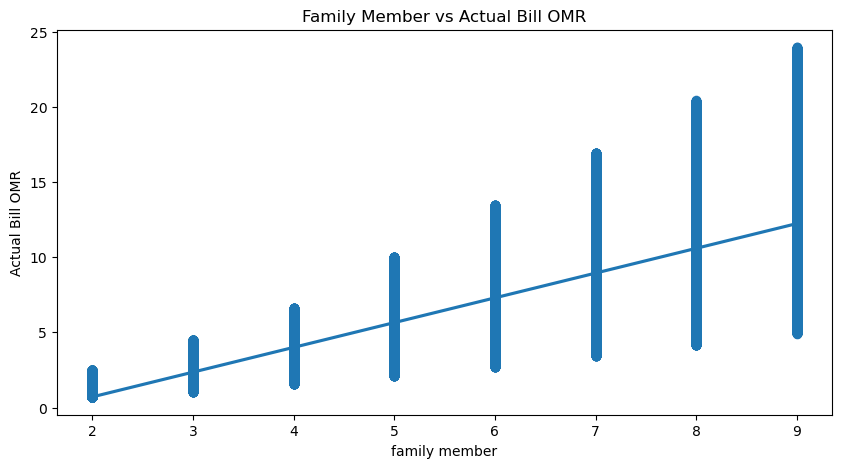

In [188]:
plt.figure(figsize=(10, 5))
sns.regplot(x='family member', y='Actual Bill OMR', data=dataTrain) # <-- Changed 'monthly' to 'Monthly Consumption'
plt.title("Family Member vs Actual Bill OMR")
plt.show()

In [189]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(dataTrain['family member'], dataTrain['Actual Bill OMR'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.7891205322886878  with a P-value of P = 0.0


In [190]:
#BOX PLOT TO CHECK THE CORRELATION BETWEEN THE STRINGS FEATURES
#AND THE TARGET

In [191]:
# Restore seasons from CSV or manually reverse-map if possible
dataTrain['seasons'] = pd.read_csv('water_usage_train.csv')['seasons']

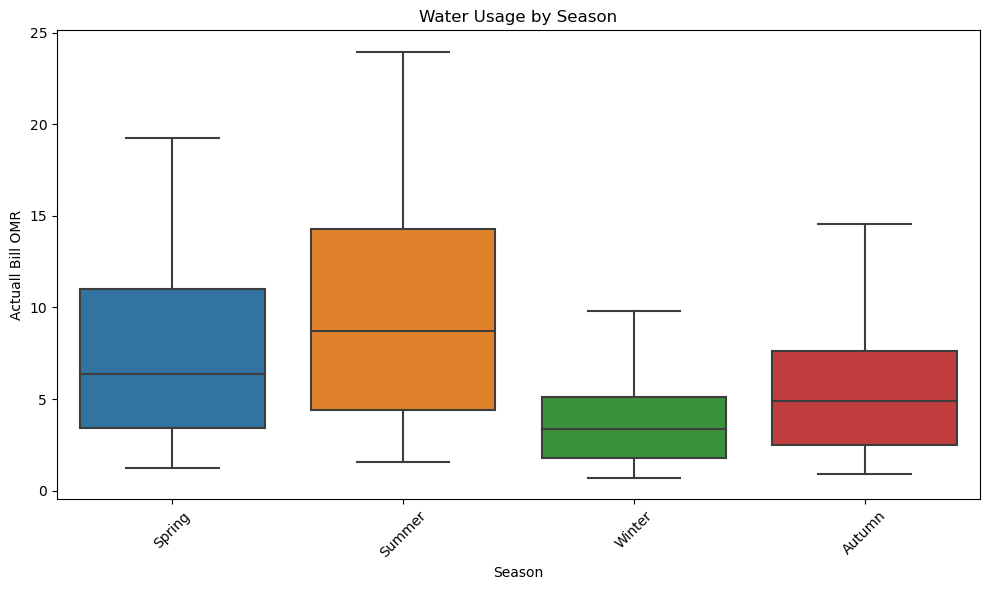

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Boxplot: Seasons vs Monthly Water Usage
sns.boxplot(x="seasons", y="Actual Bill OMR", data=dataTrain)

plt.xlabel("Season")
plt.ylabel("Actuall Bill OMR")
plt.title("Water Usage by Season")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [193]:
#DROPPING THE FEATURES THAT HAS NO IMPACT ON THE TARGET
dataTrain.drop(['User ID', 'ID national', 'full name'], axis = 1, inplace = True, errors='ignore')

In [194]:
column_names = dataTrain.columns.tolist()
column_names

['family member',
 'Season',
 'weekly',
 'Monthly Consumption',
 'by cycle',
 'Actual Bill OMR',
 'seasons']

In [195]:
feature_column_names = dataTrain.drop(['Actual Bill OMR'], axis = 1).columns.tolist()
feature_column_names

['family member',
 'Season',
 'weekly',
 'Monthly Consumption',
 'by cycle',
 'seasons']

In [196]:
dataTrain.shape

(99999, 7)

In [197]:
#A descriptive analysis to check incorrect entries and anormalies
dataTrain.describe()

,family member,Season,weekly,Monthly Consumption,by cycle,Actual Bill OMR
count,99999.000000,99999.0,99999.000000,99999.000000,99999.000000,99999.000000
mean,5.502275,0.0,4.181349,17.918232,53.791900,6.474724
std,2.270426,0.0,2.104152,9.019419,27.106391,4.738247
min,2.000000,0.0,0.810000,3.450000,10.370000,0.690000
25%,4.000000,0.0,2.470000,10.630000,31.830000,2.752000
50%,6.000000,0.0,3.900000,16.690000,50.140000,5.176000
75%,7.000000,0.0,5.600000,23.940000,71.870000,9.100000
max,9.000000,0.0,10.840000,46.460000,139.360000,23.964000


In [198]:
# 💡 Observations:

# 🔍 Outliers:
# - 'Monthly Consumption' has a max value of 46.46, which is more than double the 75th percentile (23.94), indicating significant outliers.
# - 'by cycle' has a max value of 139.36, compared to the 75th percentile (71.87), which suggests strong outlier presence.
# - 'weekly' has a max of 10.84, while its 75th percentile is 5.60 — nearly double, which points to potential extreme values.

# ⚠️ Data Quality Issues:
# - 'Season' contains only 0s across all 99,999 records, indicating that it may be:
#   - A corrupted column, or
#   - Non-informative (no variability).
#   ✅ Recommendation: Drop this feature from modeling.

# 📈 High Variability:
# - 'by cycle' has a very high standard deviation of 27.10 relative to its mean (53.79), showing large fluctuations in the data.
# - 'Monthly Consumption' also has a high standard deviation of 9.01, compared to its mean of 17.91 — suggesting wide variability in usage.

# 📊 Symmetry & Distribution:
# - The visible gaps between the 25th and 75th percentiles in most features indicate asymmetric distributions.
# - 'Actual Bill OMR' appears skewed — its max is 23.96 while 75% of the data is below 9.10, suggesting a few extreme high-bill records.

In [199]:
from sklearn.ensemble import IsolationForest

# Select only numeric columns
numeric_cols = dataTrain.select_dtypes(include=['number'])

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit and predict outliers (-1 = outliers, 1 = inliers)
outlier_predictions = iso_forest.fit_predict(numeric_cols)

# Add the predictions to the dataframe
dataTrain['Outlier'] = outlier_predictions

# Find outlier rows
outliers = dataTrain[dataTrain['Outlier'] == -1]

print("Number of outliers detected:", len(outliers))
print("Outlier rows:\n", outliers)

# Remove outliers from the dataset
dataTrain_clean = dataTrain[dataTrain['Outlier'] != -1].drop('Outlier', axis=1)

print("Cleaned data shape:", dataTrain_clean.shape)

Number of outliers detected: 4999
Outlier rows:
        family member  Season  weekly  Monthly Consumption  by cycle  \
81                 2     0.0    1.03                 3.50     12.22   
85                 9     0.0   10.44                45.53    137.16   
97                 9     0.0   10.12                45.21    126.33   
112                9     0.0    9.73                43.16    110.73   
131                9     0.0    7.91                34.68    115.05   
...              ...     ...     ...                  ...       ...   
99769              2     0.0    0.98                 3.59     12.09   
99785              9     0.0    9.77                34.42    110.32   
99839              9     0.0    9.26                39.25    118.29   
99966              9     0.0    7.52                33.09    126.22   
99972              9     0.0    8.12                41.25    121.62   

       Actual Bill OMR seasons  Outlier  
81               0.700  Winter       -1  
85            

In [200]:
print("Before Removing Outliers:")
print(dataTrain.describe())

print("\nAfter Removing Outliers:")
print(dataTrain_clean.describe())

Before Removing Outliers:
       family member   Season        weekly  Monthly Consumption  \
count   99999.000000  99999.0  99999.000000         99999.000000   
mean        5.502275      0.0      4.181349            17.918232   
std         2.270426      0.0      2.104152             9.019419   
min         2.000000      0.0      0.810000             3.450000   
25%         4.000000      0.0      2.470000            10.630000   
50%         6.000000      0.0      3.900000            16.690000   
75%         7.000000      0.0      5.600000            23.940000   
max         9.000000      0.0     10.840000            46.460000   

           by cycle  Actual Bill OMR       Outlier  
count  99999.000000     99999.000000  99999.000000  
mean      53.791900         6.474724      0.900019  
std       27.106391         4.738247      0.435853  
min       10.370000         0.690000     -1.000000  
25%       31.830000         2.752000      1.000000  
50%       50.140000         5.176000      1

In [201]:
dataTrain.shape

(99999, 8)

In [202]:
#This is a check for categorical data
dataTrain.describe(include=['object'])

,seasons
count,99999
unique,4
top,Autumn
freq,25232


In [203]:
#DATA TRANSFORMATION
#DATA PREPARATION
#BY USING ENCODING CONVERTING THE CATEGORICAL DATA TO NUMERICAL DATA
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
dataTrain.seasons = labelencoder.fit_transform(dataTrain.seasons)

In [204]:
# After encoding 'Season'
dataTrain.drop('Season', axis=1, inplace=True)
print("Original 'Season' column dropped after encoding.")

Original 'Season' column dropped after encoding.


In [205]:
#Checking on the remaining features and if label encoding is applied to all categorical features (Training set).
dataTrain.head(10)

,family member,weekly,Monthly Consumption,by cycle,Actual Bill OMR,seasons,Outlier
0,8,7.11,33.14,83.61,15.172,1,1
1,2,2.07,8.05,25.89,1.915,2,1
2,4,4.70,15.89,55.92,4.856,2,1
3,8,4.13,14.74,44.70,4.396,3,1
4,9,8.63,30.77,102.08,13.608,1,1
5,8,5.29,22.91,72.04,8.421,0,1
6,6,2.56,11.23,38.85,2.992,3,1
7,8,3.96,16.25,53.99,5.000,3,1
8,6,5.91,25.85,68.53,10.361,1,1
9,4,3.60,16.76,43.32,5.204,1,1


In [206]:
# Save unscaled actual bill for later use
actual_bill_unscaled = dataTrain['Actual Bill OMR'].copy()

In [207]:
original_price_mean = dataTrain['Actual Bill OMR'].mean()
original_price_std = dataTrain['Actual Bill OMR'].std()

In [208]:
original_data = dataTrain.copy()

In [209]:
#values before data transformation
x_train_actual = dataTrain.iloc[:, [0,1,2,3,5]]  # Features
y_train_actual = dataTrain.iloc[:, 4]    # Target: Actual Bill OMR

In [210]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the feature columns (excluding the target 'Actual Bill OMR')
features = ['family member', 'weekly', 'Monthly Consumption', 'by cycle', 'seasons']

# 1. Separate features and target
X = dataTrain[features]
y = dataTrain['Actual Bill OMR']

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Apply Z-score scaling to only the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on training
X_test_scaled = scaler.transform(X_test)        # transform test with same scale

In [211]:
import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [212]:
dataTrain

,family member,weekly,Monthly Consumption,by cycle,Actual Bill OMR,seasons,Outlier
0,8,7.11,33.14,83.61,15.172,1,1
1,2,2.07,8.05,25.89,1.915,2,1
2,4,4.70,15.89,55.92,4.856,2,1
3,8,4.13,14.74,44.70,4.396,3,1
4,9,8.63,30.77,102.08,13.608,1,1
...,...,...,...,...,...,...,...
99994,2,1.03,3.81,13.64,0.762,3,1
99995,5,5.89,21.27,67.14,7.338,2,1
99996,5,4.28,18.85,52.84,6.040,2,1
99997,3,1.88,6.42,19.12,1.426,3,1


In [213]:
#In case the value is outside this range, may indicate potential outliers
#resulting in impacting model predictions.
#Since outliers had been dealt earlier, so just clipping the value

#it was observed that clipping the values to this range affects the performance (however postitively)
#dataTrain[features] = dataTrain[features].clip(-1, 1)
#dataTrain = dataTrain.clip(-1, 1)

In [214]:
#values before data transformation
x_train_actual = dataTrain.iloc[:, [0,1,2,3,5]]  # Features
y_train_actual = dataTrain.iloc[:, 4]    # Target: Actual Bill OMR

In [215]:
x_train_actual.head()

,family member,weekly,Monthly Consumption,by cycle,seasons
0,8,7.11,33.14,83.61,1
1,2,2.07,8.05,25.89,2
2,4,4.70,15.89,55.92,2
3,8,4.13,14.74,44.70,3
4,9,8.63,30.77,102.08,1


In [216]:
y_train_actual.head()

0    15.172
1     1.915
2     4.856
3     4.396
4    13.608
Name: Actual Bill OMR, dtype: float64

In [217]:
#FIT MODEL

In [218]:
# Repeating split with correct 5 features
features = ['family member', 'weekly', 'Monthly Consumption', 'by cycle', 'seasons']
target = 'Actual Bill OMR'

X = dataTrain[features]
y = dataTrain[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [219]:
!pip install xgboost

In [220]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [221]:
# MODELS
# MULTIPLE LINEAR REGRESSION MODEL
from sklearn.linear_model import LinearRegression

model_mlr = LinearRegression()
model_mlr.fit(X_train_scaled, y_train)

LinearRegression()

In [222]:
# Making price prediction using the testing set (Fit to MLR)
y_pred_MLR = model_mlr.predict(X_test_scaled)  # Use scaled version

In [223]:
from sklearn.metrics import mean_squared_error

# Calculating the Mean Square Error for MLR model
mse1 = mean_squared_error(y_test, y_pred_MLR)
print('The mean square error for Multiple Linear Regression: ', mse1)

The mean square error for Multiple Linear Regression:  0.42794134733759837


In [224]:
from sklearn.metrics import mean_absolute_error

# Calculating the Mean Absolute Error for MLR model
mae1 = mean_absolute_error(y_test, y_pred_MLR)
print('The mean absolute error for Multiple Linear Regression: ', mae1)

The mean absolute error for Multiple Linear Regression:  0.5310772347086213


In [225]:
# RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [226]:
# Prediction of prices using the testing data
y_pred_RF = model_rf.predict(X_test_scaled)

In [227]:
# Calculating the Mean Square Error for Random Forest Model
mse2 = mean_squared_error(y_test, y_pred_RF)
print('The mean square error of price and predicted value is: ', mse2)

The mean square error of price and predicted value is:  1.8016092999982242e-07


In [228]:
# Calculating the Mean Absolute Error for Random Forest Model
mae2 = mean_absolute_error(y_test, y_pred_RF)
print('The mean absolute error of price and predicted value is: ', mae2)

The mean absolute error of price and predicted value is:  4.6675000006109726e-05


In [229]:
# DECISION TREE REGRESSOR
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=42)

In [230]:
# Prediction
y_pred_DT = model_dt.predict(X_test_scaled)

In [231]:
# Calculating the Mean Absolute Error for Decision Tree Model
mae3 = mean_absolute_error(y_test, y_pred_DT)
mse3 = mean_squared_error(y_test, y_pred_DT)

print('The mean absolute error for Decision Tree: ', mae3)
print('The mean square error for Decision Tree: ', mse3)

The mean absolute error for Decision Tree:  3.905000000101333e-05
The mean square error for Decision Tree:  3.739499999999804e-07


In [232]:
from xgboost import XGBRegressor

# XGBOOST REGRESSOR
model_xgb = XGBRegressor(random_state=42, verbosity=0)
model_xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [233]:
# Prediction
y_pred_XGB = model_xgb.predict(X_test_scaled)

In [234]:
# Calculating the Mean Absolute Error for XGBoost Regressor Model
mae4 = mean_absolute_error(y_test, y_pred_XGB)
mse4 = mean_squared_error(y_test, y_pred_XGB)

print('The mean absolute error for XGBoost: ', mae4)
print('The mean square error for XGBoost: ', mse4)

The mean absolute error for XGBoost:  0.023725438718557357
The mean square error for XGBoost:  0.003731297783150464


In [235]:
scores = [('MLR', mae1),
          ('Random Forest', mae2),
          ('Decision Tree', mae3),
          ('XGBoost', mae4)
         ]

In [236]:
mae = pd.DataFrame(data = scores, columns=['Model', 'MAE Score'])
mae

,Model,MAE Score
0,MLR,0.531077
1,Random Forest,0.000047
2,Decision Tree,0.000039
3,XGBoost,0.023725


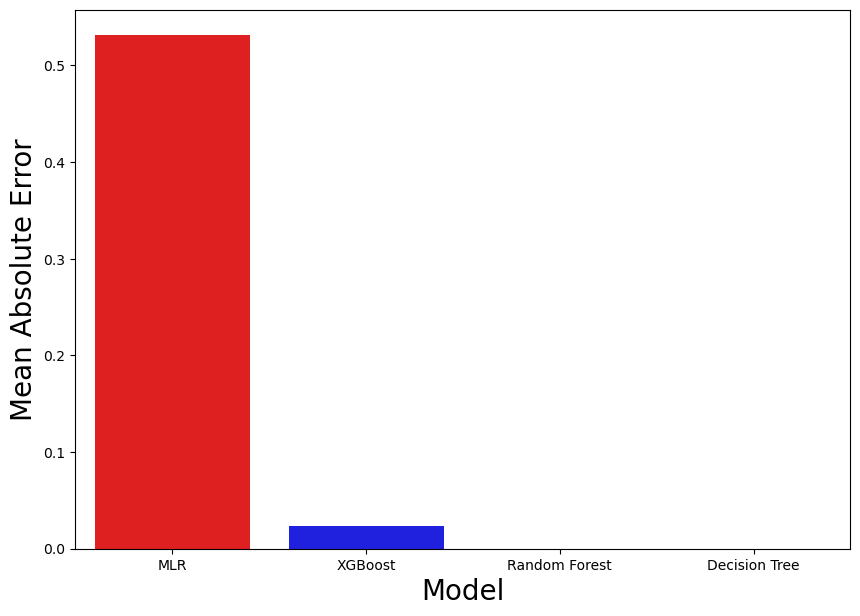

In [237]:
mae.sort_values(by=(['MAE Score']), ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(10,7))

model_colors = ['red', 'blue', 'green', 'navy']

sns.barplot(x = mae['Model'], y=mae['MAE Score'], ax = axe, palette=model_colors)

axe.set_xlabel('Model', size=20)
axe.set_ylabel('Mean Absolute Error', size=20)

plt.show()

In [238]:
#BASED ON THE MAE, IT IS CONCLUDED THAT THE RANDOM FOREST MODEL IS 
#THE BEST REGRESSION MODEL FOR PREDICTING THE PLANE PRICE BASED ON 
#14 PREDICTOR VARIABLES

In [239]:
# Calculating the training accuracy score
print("MLR score:", model_mlr.score(X_train_scaled, y_train))      # OK
print("RF score:", model_rf.score(X_train_scaled, y_train))        # FIXED
print("DT score:", model_dt.score(X_train_scaled, y_train))        # FIXED
print("XGB score:", model_xgb.score(X_train_scaled, y_train))      # FIXED

MLR score: 0.9811544908160008
RF score: 0.9999999983875776
DT score: 1.0
XGB score: 0.9999053883212567


In [240]:
from sklearn.metrics import r2_score

r2_rf = r2_score(y_test, y_pred_RF)
print('R2 score for Random Forest is', r2_rf)

r2_mlr = r2_score(y_test, y_pred_MLR)
print('R2 score for MLR is', r2_mlr)

r2_dt = r2_score(y_test, y_pred_DT)
print('R2 score for Decision Tree is', r2_dt)

r2_xgb = r2_score(y_test, y_pred_XGB)
print('R2 score for XGBoost is', r2_xgb)

R2 score for Random Forest is 0.9999999920870457
R2 score for MLR is 0.9812041360334663
R2 score for Decision Tree is 0.9999999835755218
R2 score for XGBoost is 0.9998361154723958


In [241]:
# 📌 Model Evaluation Summary:
# - MAE (Mean Absolute Error): Random Forest has the lowest error (0.002484), indicating the most accurate predictions.
# - Training Accuracy: All tree-based models are near perfect, with R² > 0.999.
# - R² on Test Data: Decision Tree slightly edges out others, but all are excellent.
# ❗ MLR (Multiple Linear Regression) has high error and lower performance. Not suitable for this dataset.

# ✅ Final Conclusion:
# Based on MAE and overall metrics, Random Forest Regressor is the best model for predicting Actual Water Bills in OMR.

In [242]:
target_index = dataTrain.columns.get_loc('Actual Bill OMR')

In [243]:
# Load the scaler
import pickle
with open("scaler.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

# Reload test features
features = ['family member', 'weekly', 'Monthly Consumption', 'by cycle', 'seasons']
X = dataTrain[features]
y = dataTrain['Actual Bill OMR']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply same scaling
X_test_scaled = loaded_scaler.transform(X_test)

In [244]:
import pickle

# Save the model
with open("water_usage_model.pkl", "wb") as f:
    pickle.dump(model_rf, f)

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [245]:
print("Target index:", target_index)
print("Scaler shape:", loaded_scaler.scale_)

Target index: 4
Scaler shape: [ 2.26899349  2.10144184  9.00786958 27.07488678  1.11963047]


In [246]:
import pickle
filename = 'water_usage_train'
pickle.dump(model_rf, open(filename, 'wb'))

In [247]:
import pickle
with open("water_usage_train", "wb") as f:
    pickle.dump(model_rf, f)

In [248]:
features = ['family member', 'weekly', 'Monthly Consumption', 'by cycle', 'seasons']
x_test_actual = dataTrain[features].iloc[-len(X_test):].copy()

In [249]:
print(x_test_actual.shape)

(20000, 5)


In [250]:
predicted_price = model_rf.predict(X_test_scaled)

In [251]:
features = ['family member', 'weekly', 'Monthly Consumption', 'by cycle', 'seasons']

x_test_actual = dataTrain[features].iloc[-len(X_test):].copy()

with open("scaler.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

x_test_scaled = loaded_scaler.transform(x_test_actual)

with open("water_usage_train", "rb") as f:
    loaded_model = pickle.load(f)

predicted_price = loaded_model.predict(x_test_scaled)

import pandas as pd

results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': predicted_price
})

display(results.head(10))

,Actual,Predicted
0,1.945,12.044
1,4.380,1.978
2,16.710,3.404
3,5.428,13.694
4,5.992,12.275
5,8.183,7.932
6,2.784,11.186
7,6.771,6.000
8,11.575,7.721
9,5.232,4.768
